In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

Train size ≃ 27.23%
Test size ≃ 72.77%


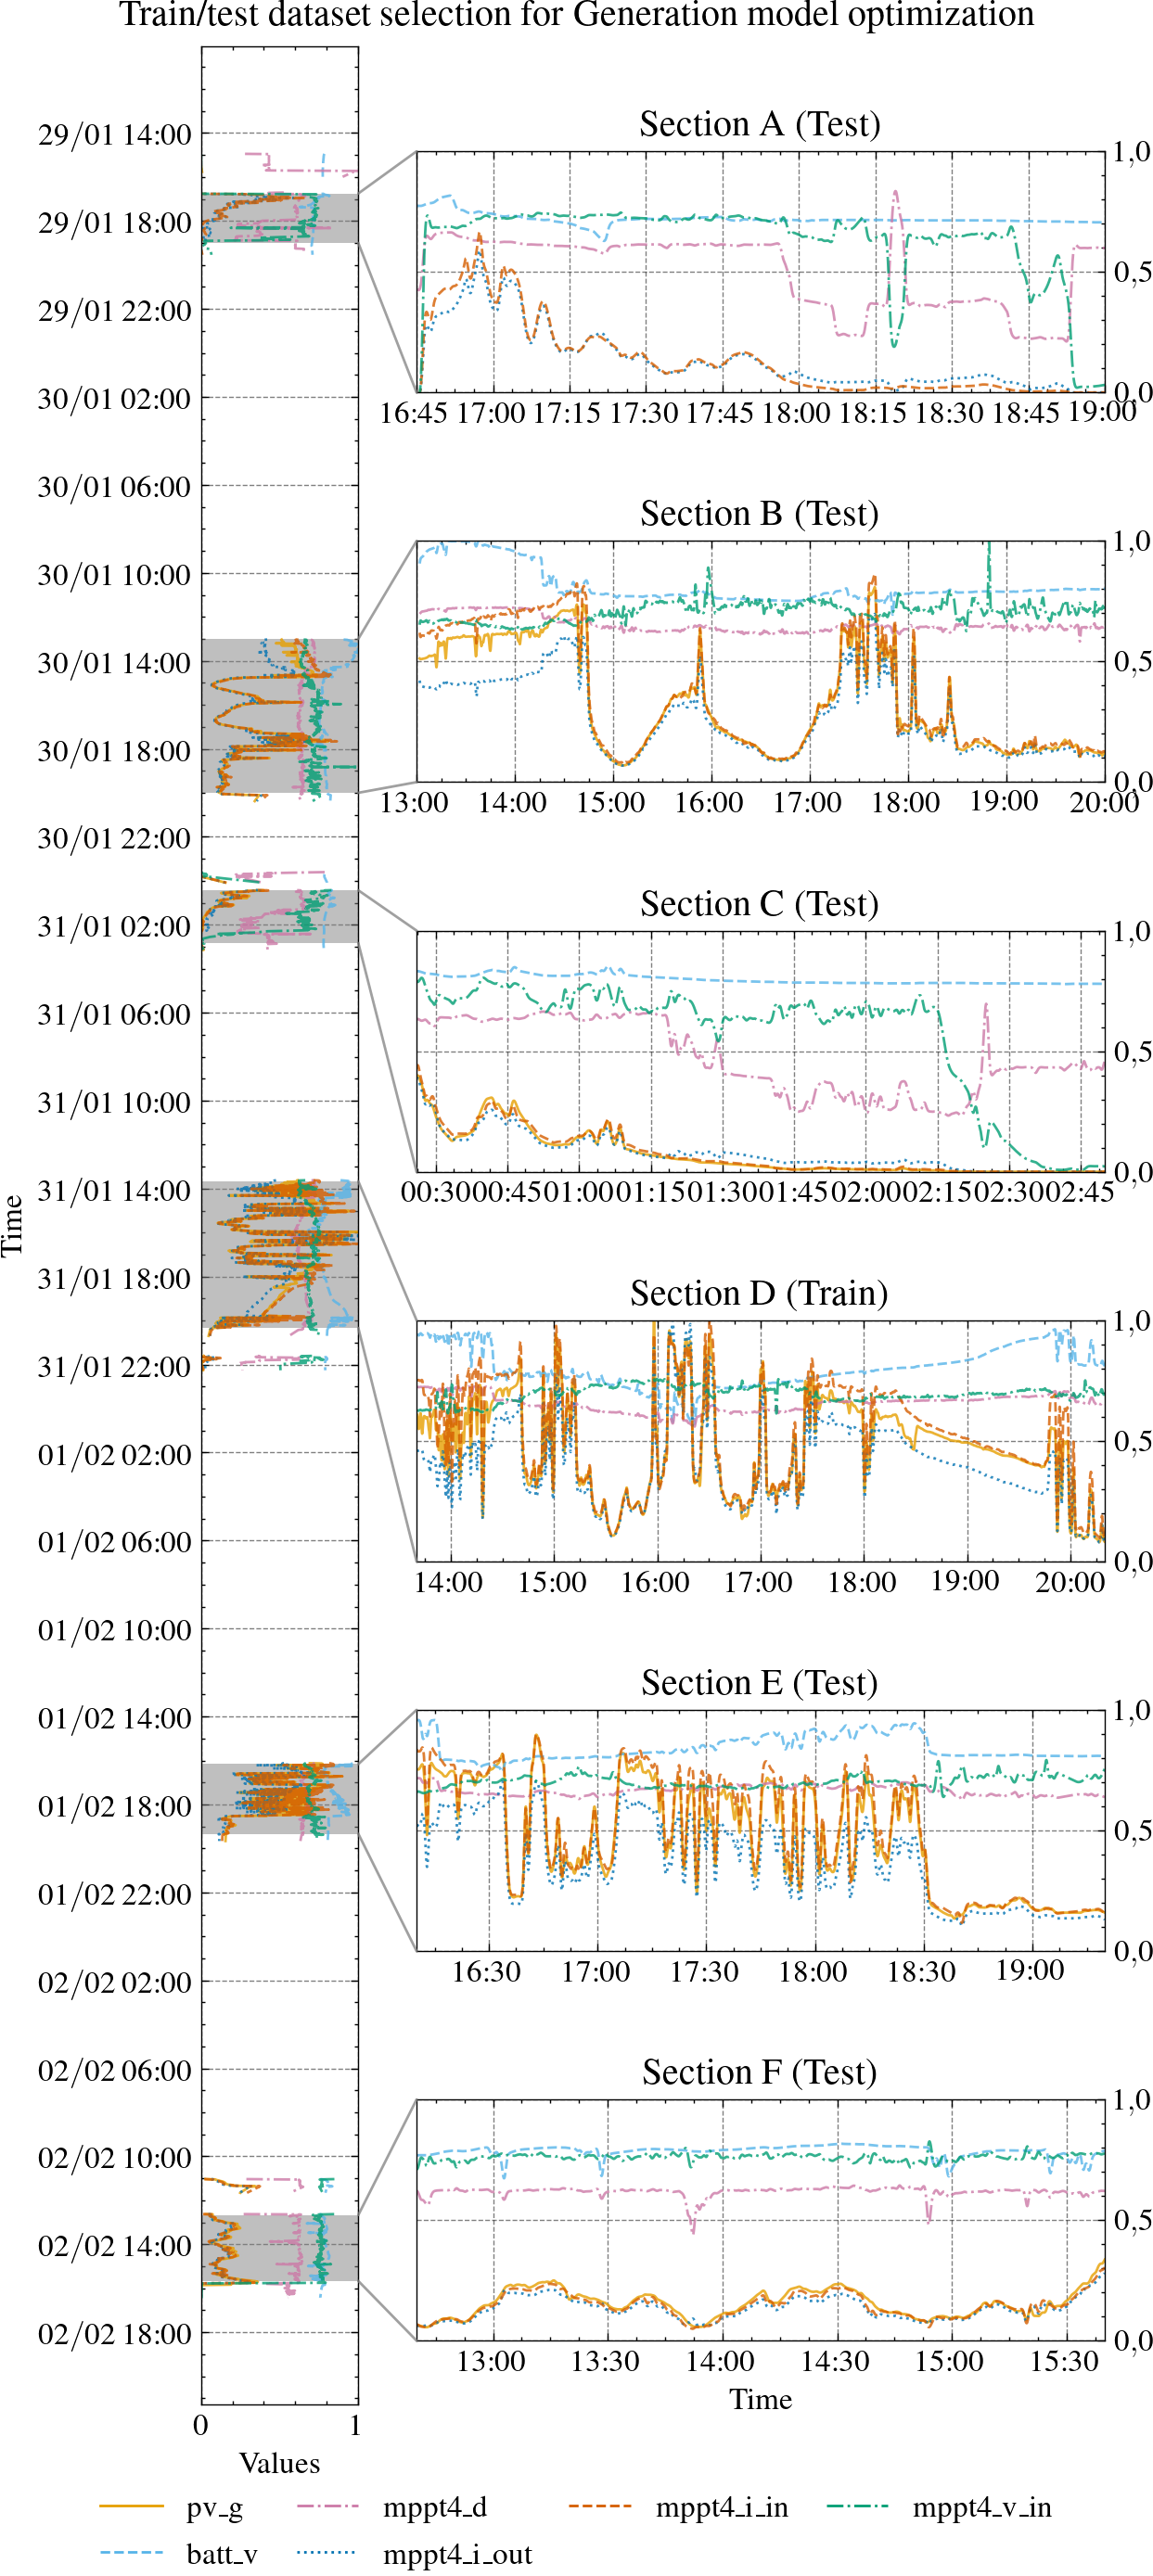

In [2]:
from fractions import Fraction

filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    # 'Battery Current': 'batt_i',
    # 'ESC Duty Cycle': 'esc_d',
    # 'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    # 'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    'PVs G': 'pv_g',
    'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}

df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule='1s',
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=0.5,
    cutoff_freq=1/100,
    sampling_rate=1,
    order=2,
)

sections, tzinfo = get_sections()
train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/generation_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=["pv_g", "batt_v", 'mppt4_d', 'mppt4_i_out', 'mppt4_i_in', 'mppt4_v_in'],
            normalize=True,
        )
    )


# Generation System model

In [3]:
from model import Generation

Generation.build({})


<NonlinearIOSystem generation: ['pv_g', 'batt_v', 'mppt4_d'] -> ['mppt4_i_out', 'mppt4_i_in', 'mppt4_v_in']>

In [4]:
generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1588,
    'mppt_eta': 0.9259,
    'mppts_n': 4,
}

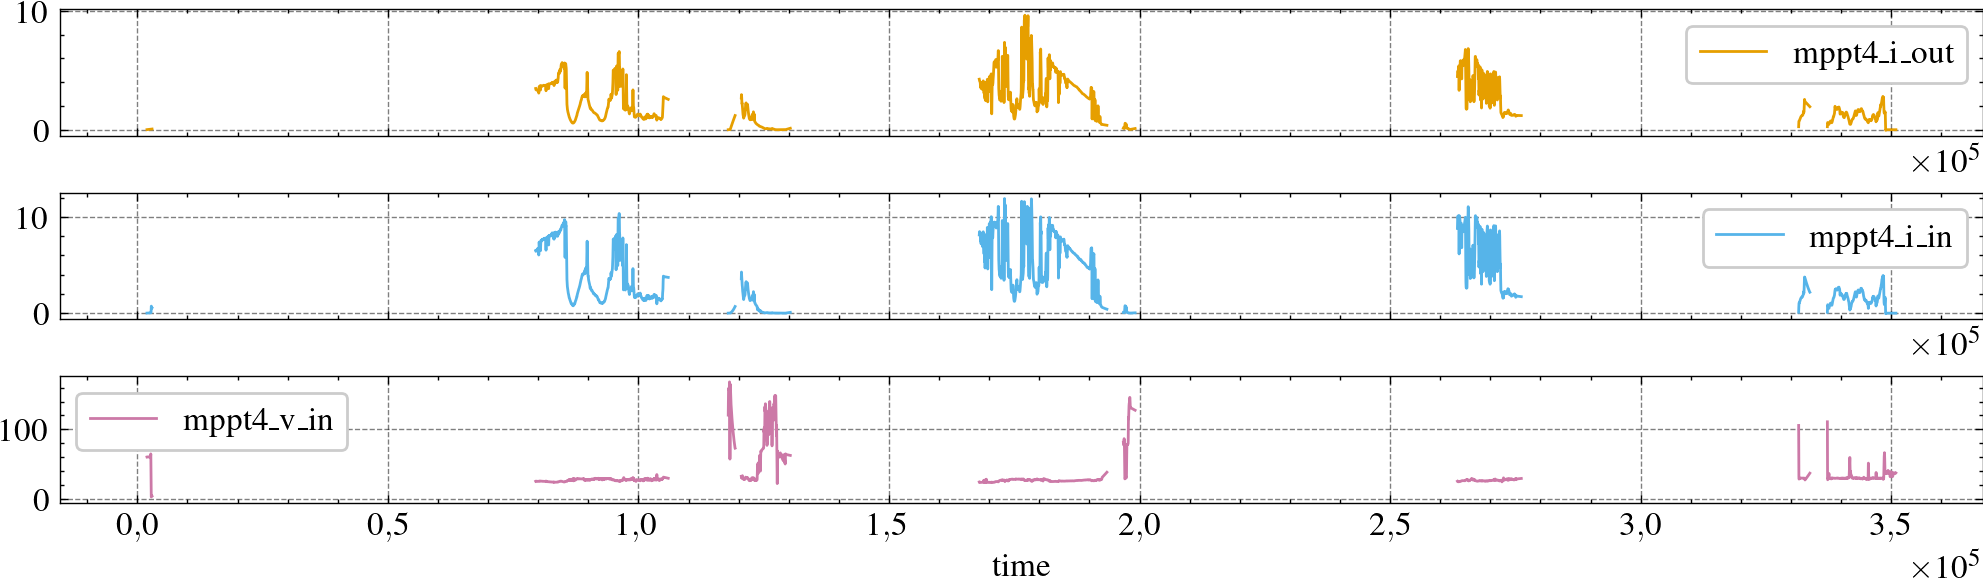

In [5]:
# Time array
T = df['t'].to_numpy()

# Inputs
U = df[['pv_g', 'batt_v', 'mppt4_d']].to_numpy().T

# Model
generation = Generation.build(generation_params)

# Initial state
X0 = np.zeros(generation.nstates)
# X0[generation.state_index['']] = 1

# Simulation
res = ct.input_output_response(generation, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,3))
plt.show()

# Optimization

In [6]:
from sklearn.preprocessing import RobustScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Generation.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       80 |  2.6649330685 |  0.0335952314
     2 |      160 |  0.8262755513 |  0.0335952314
     3 |      240 |  0.3762180354 |  0.0335952314
     4 |      320 |  0.1647745909 |  0.0335952314
     5 |      400 |  0.0913679556 |  0.0328789850
     6 |      480 |  0.0661465587 |  0.0328789850
     7 |      560 |  0.0473158320 |  0.0328789850
     8 |      640 |  0.0394345307 |  0.0328789850
     9 |      720 |  0.0362334499 |  0.0328692099
    10 |      800 |  0.0346211808 |  0.0328692099
    11 |      880 |  0.0341152883 |  0.0328692099
    12 |      960 |  0.0333518211 |  0.0328692099
    13 |     1040 |  0.0331135234 |  0.0328692099
    14 |     1120 |  0.0329460725 |  0.0328677398
    15 |     1200 |  0.0329085621 |  0.0328677398
    16 |     1280 |  0.0328861511 |  0.0328663281
    17 |     1360 |  0.0328794698 |  0.0328661314
    18 |     1440 |  0.0328740820 |  0.0328661306
    19 |     1520 |  0.0328713412 |  0.0328661306


{'pv_eta': 0.1588, 'mppt_eta': 0.9259}

Best parameters found:


{'pv_eta': 0.15553707966836625, 'mppt_eta': 0.9169847543904102}

Objective value at solution: [0.03286608]


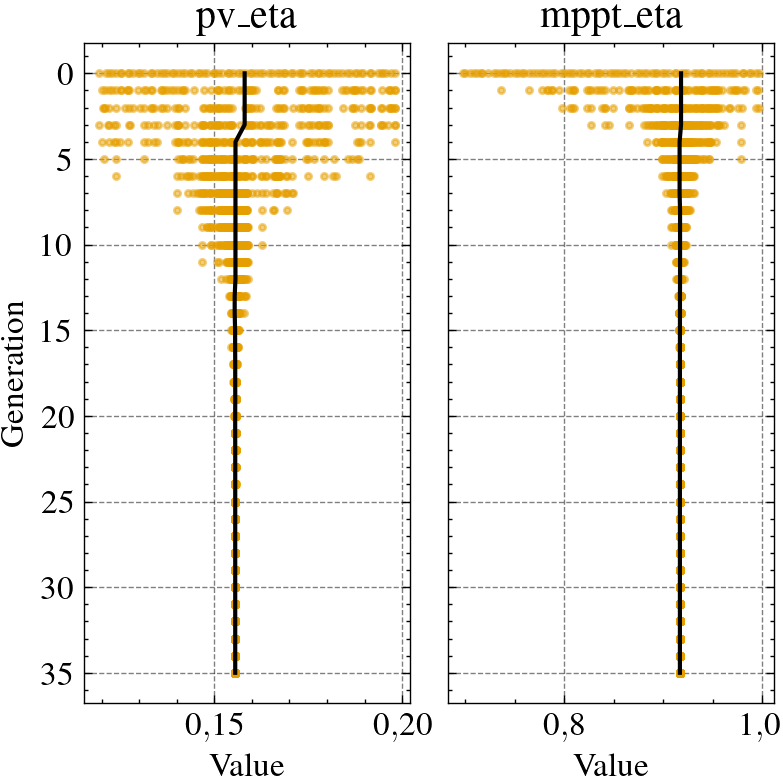

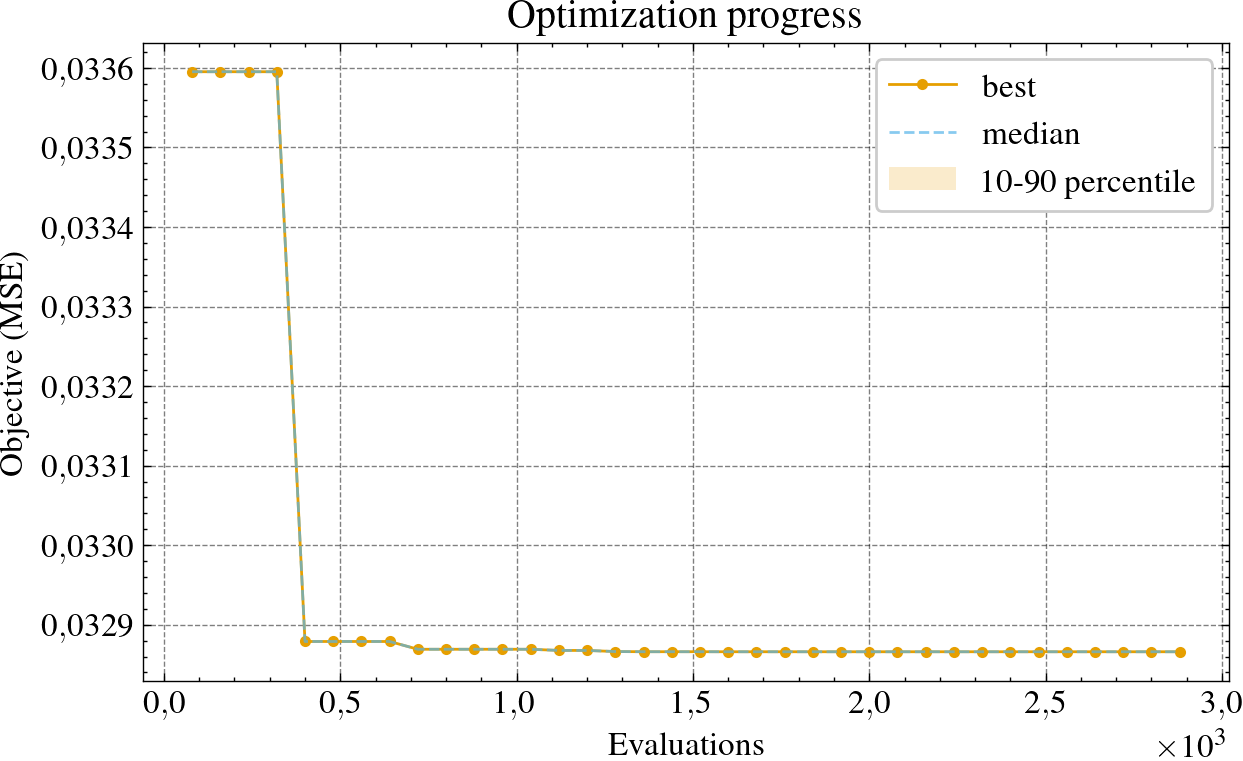

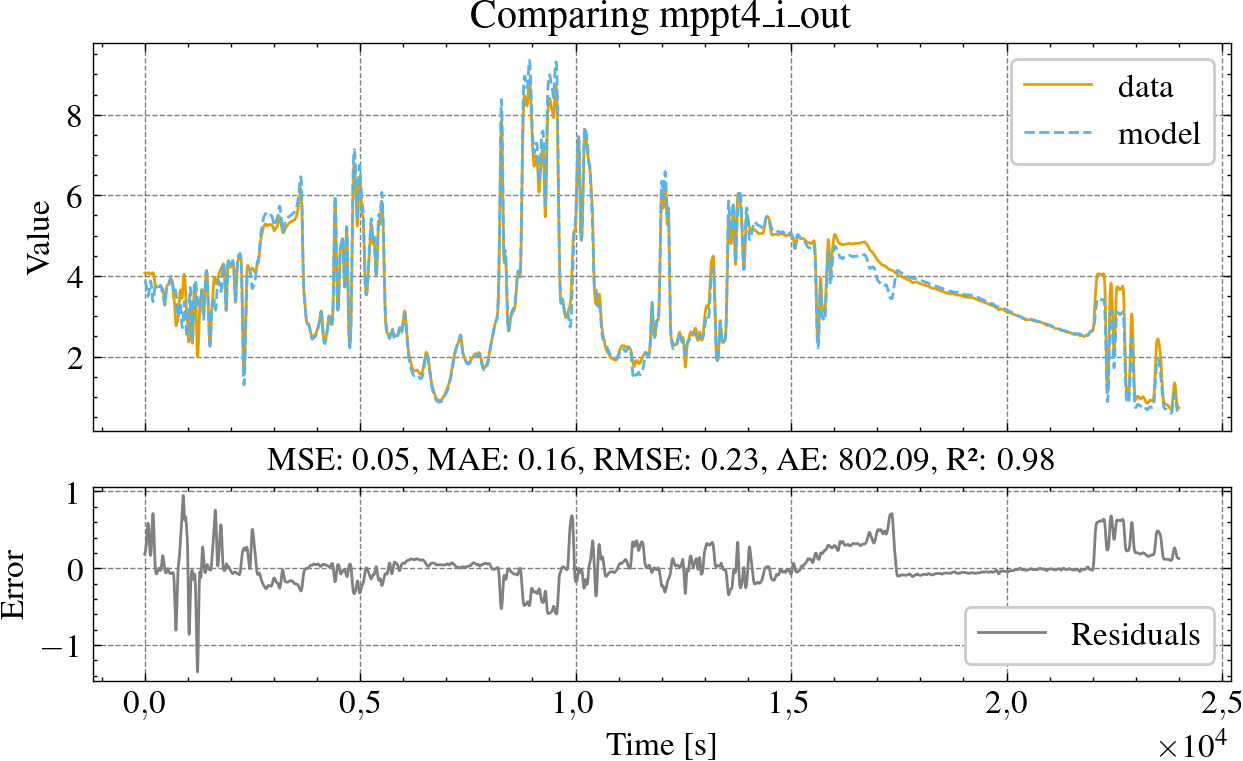

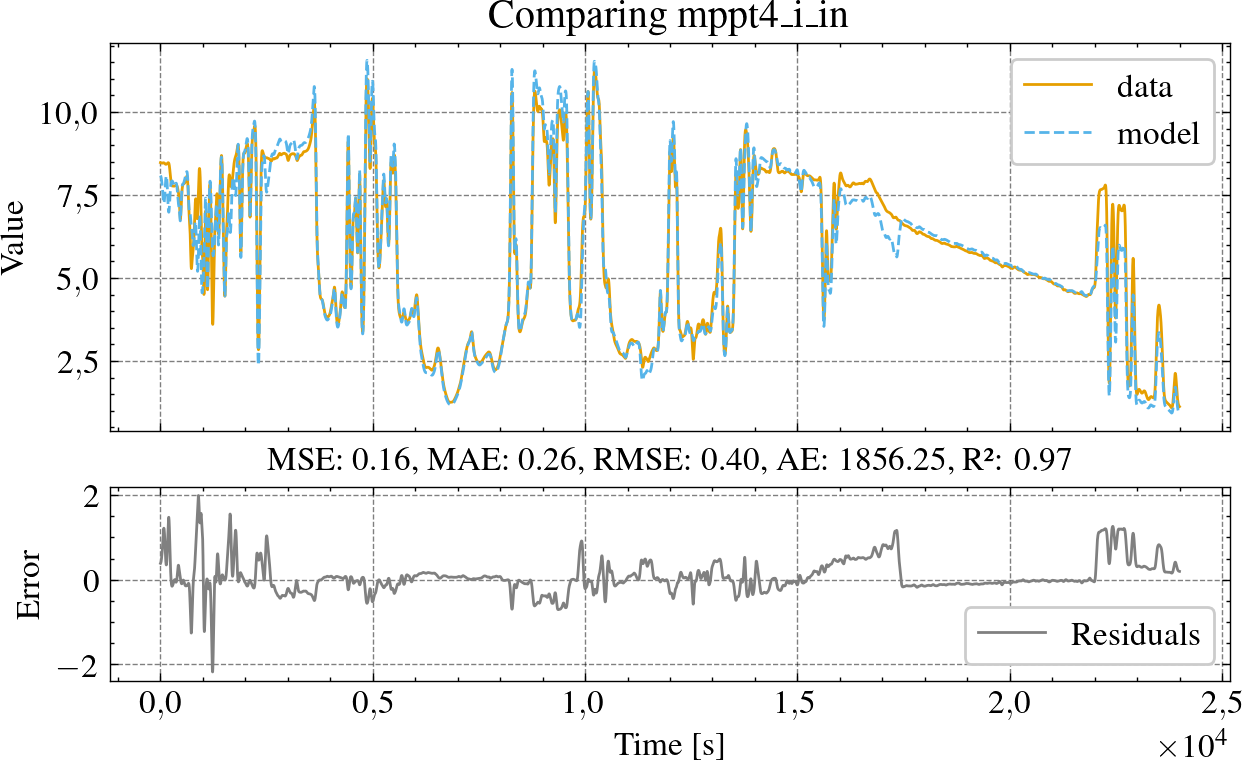

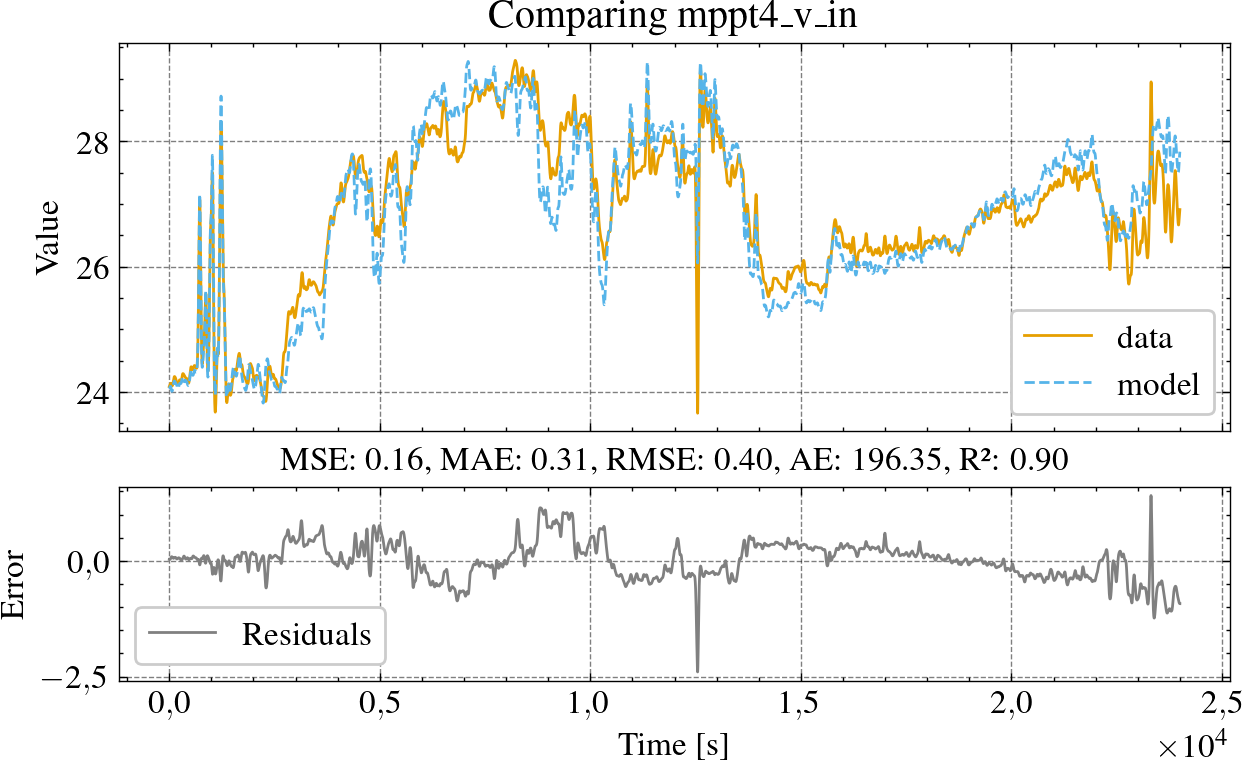

CPU times: user 3.32 s, sys: 2.86 s, total: 6.18 s
Wall time: 24.3 s


In [7]:
%%time
## GENERATION OPTIMIZATION

# Select the optimization data
data_cols = ['mppt4_i_out', 'mppt4_i_in', 'mppt4_v_in']
input_cols = ['pv_g', 'batt_v', 'mppt4_d']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
variation = 25/100
model_params = generation_params
params_bounds = {
    'pv_eta': dict(min=max(0, model_params['pv_eta']*(1-variation)), max=min(1, model_params['pv_eta']*(1+variation))),
    'mppt_eta': dict(min=max(0, model_params['mppt_eta']*(1-variation)), max=min(1, model_params['mppt_eta']*(1+variation))),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = Generation
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=RobustScaler,
    elementwise_runner=runner,
    print_exceptions=True,
)

algorithm = DE(
    pop_size=40*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
    dither='array'
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)


In [8]:
params_output_path = 'generation_params.json'
save_model_params_to_json(params_output_path, generation_params | best_params)
model_params = load_model_params_from_json(params_output_path)
model_params


{'mppt_eta': 0.9169847543904102,
 'mppts_n': 4,
 'pv_S': 1.6367999999999998,
 'pv_eta': 0.15553707966836625}

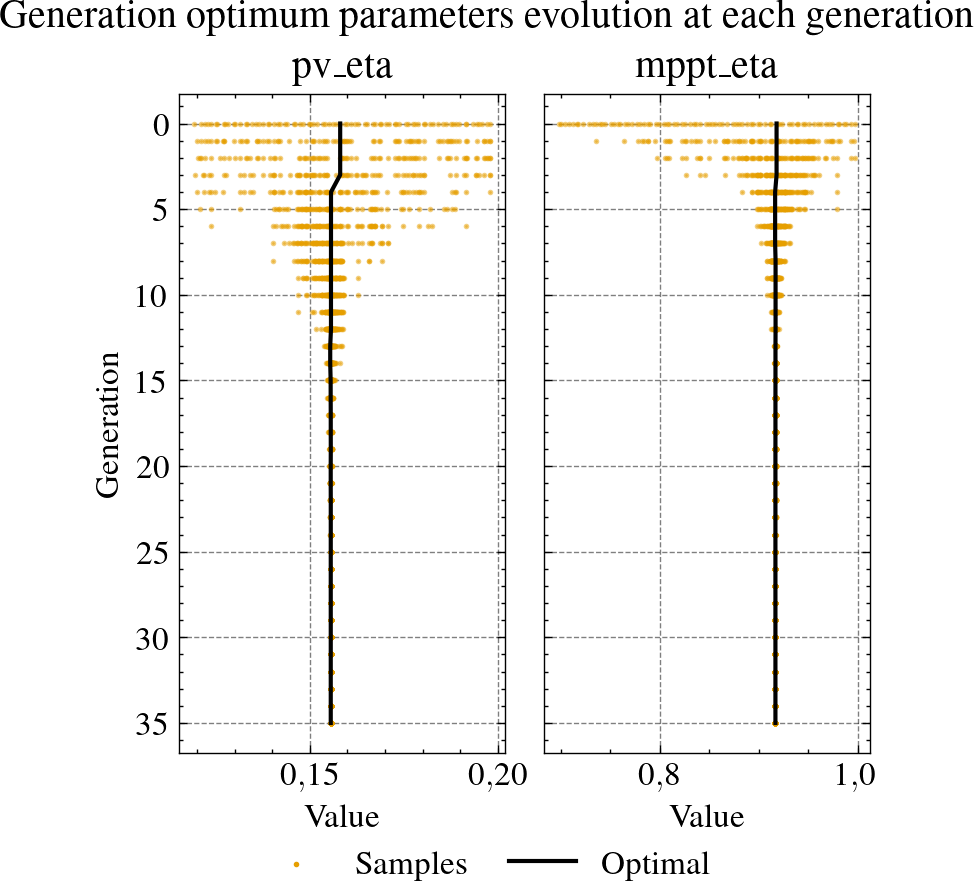

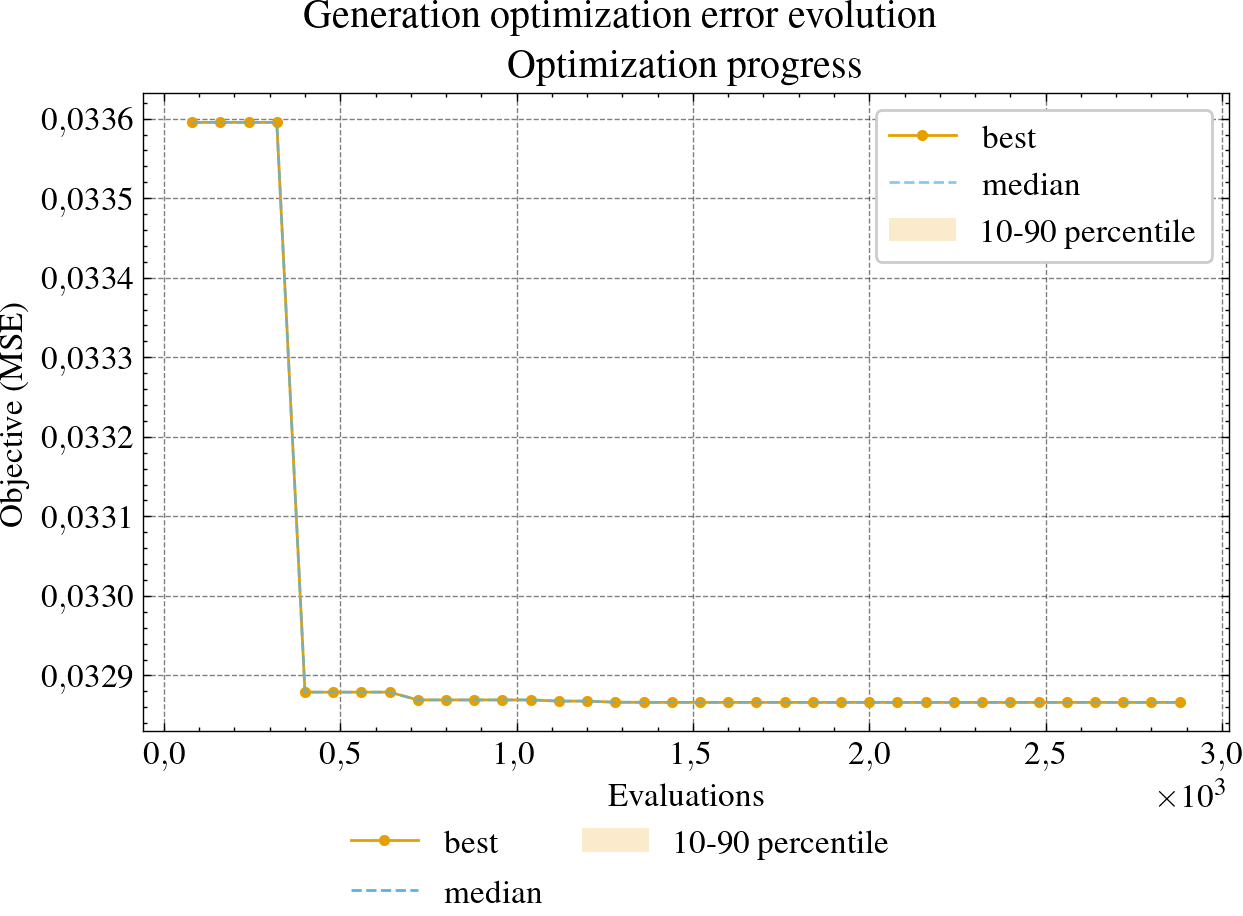

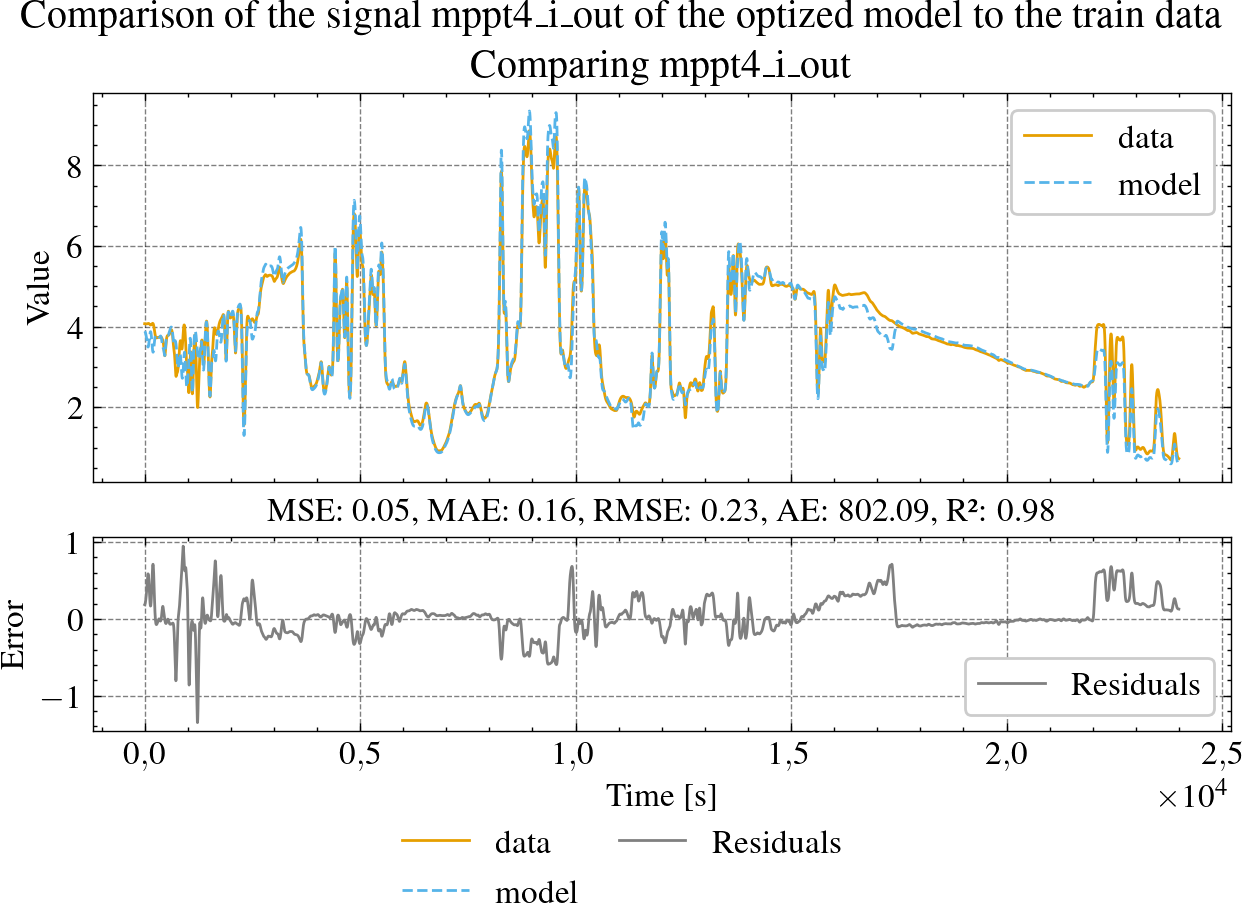

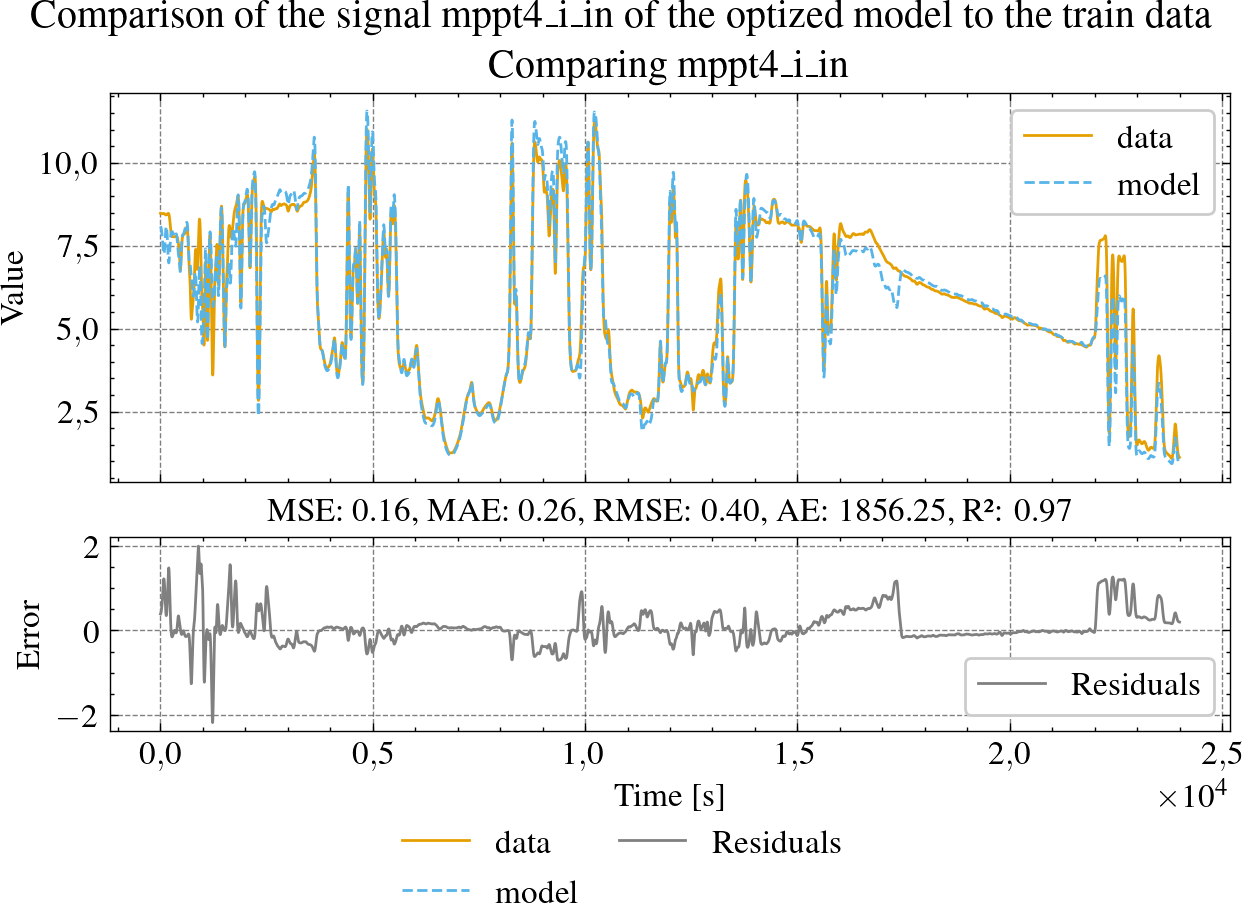

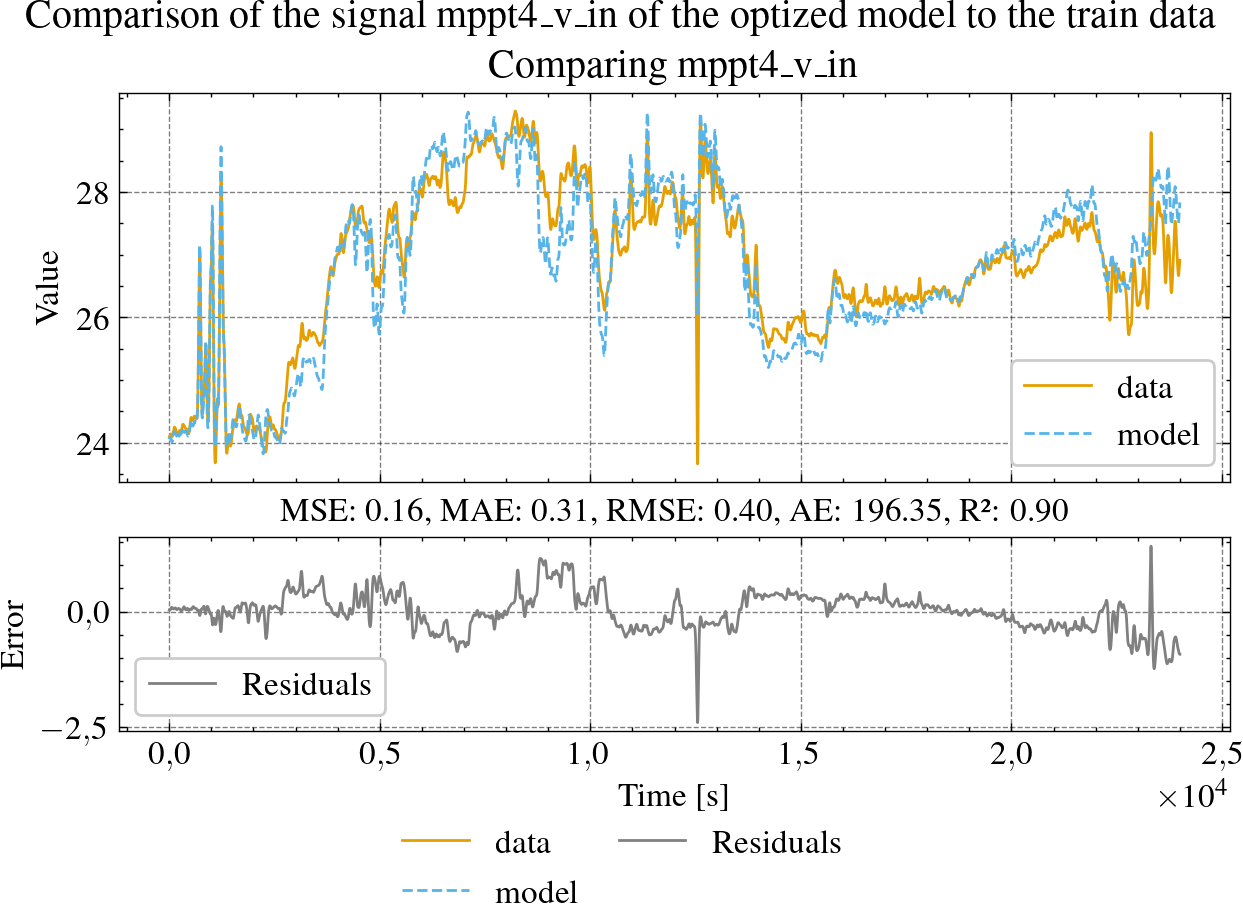

In [9]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_params.pdf',
    show_title='Generation optimum parameters evolution at each generation',
    save_title='Evolução dos parâmetros ótimos do modelo PVs+MPPTs à cada geração',
    ncol=2,
    fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, show=False)
)

fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_error.pdf',
    show_title='Generation optimization error evolution',
    save_title='Evolução do erro de otimização do modelo da Geração',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/generation_optimization_residuals_{col}_train.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the train data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
        ncol=2,
        fig=plot_compare(df_train, best_fit_data, col, show=False),
    )

Ignoring section A  because of insufficient size
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_out_test_b.pdf


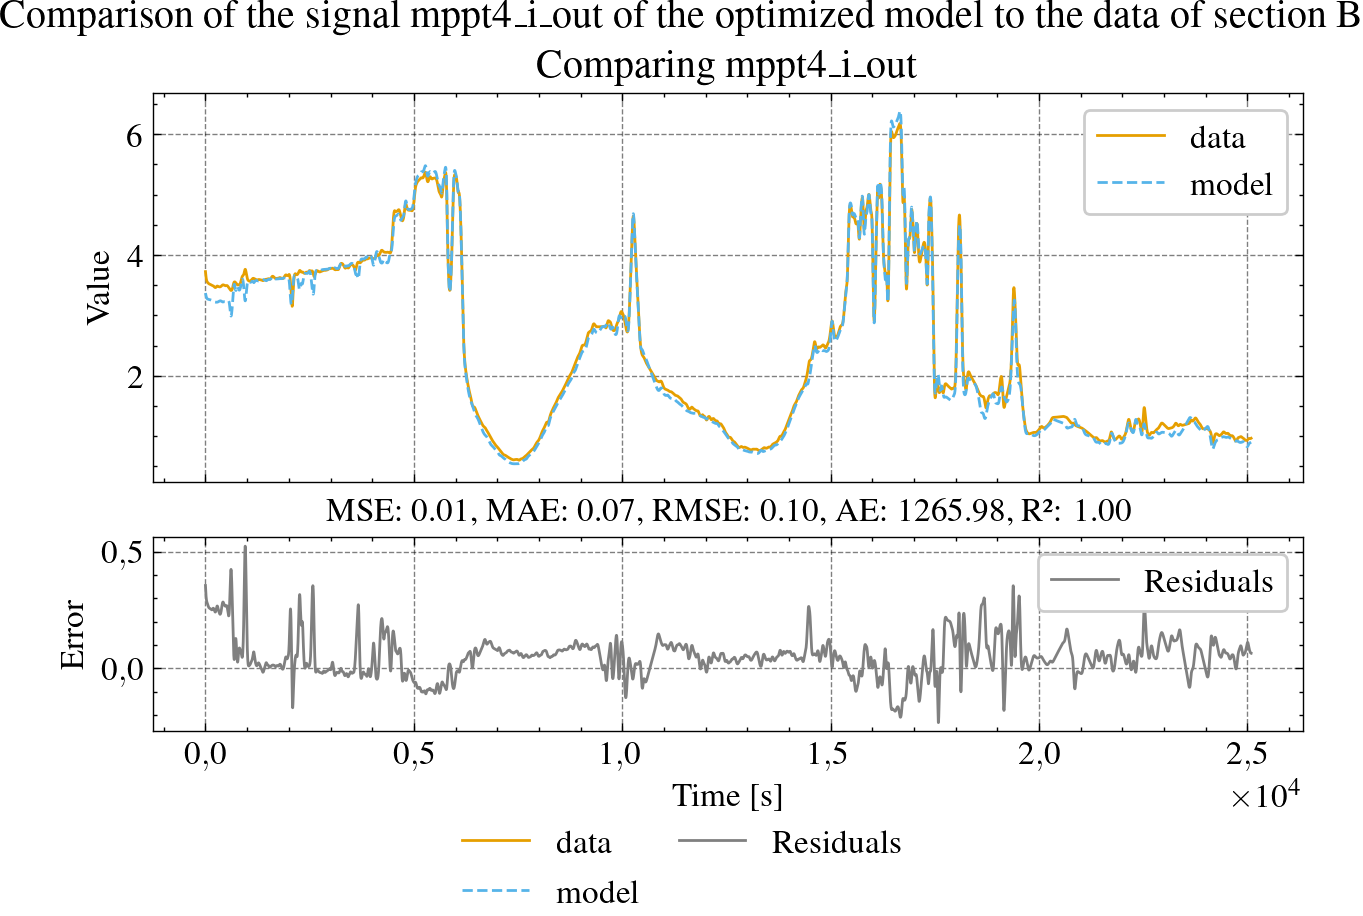

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_in_test_b.pdf


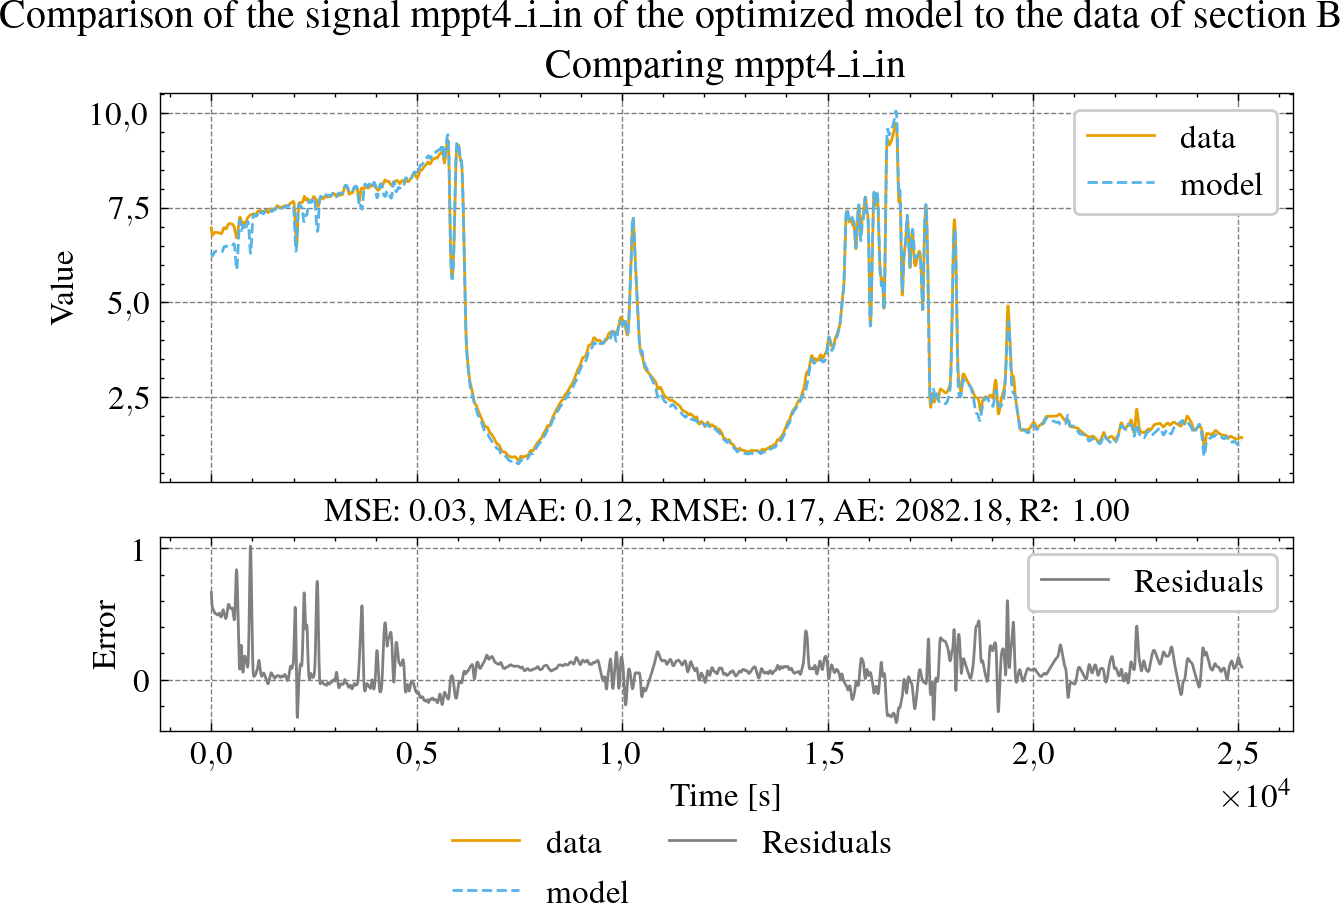

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_v_in_test_b.pdf


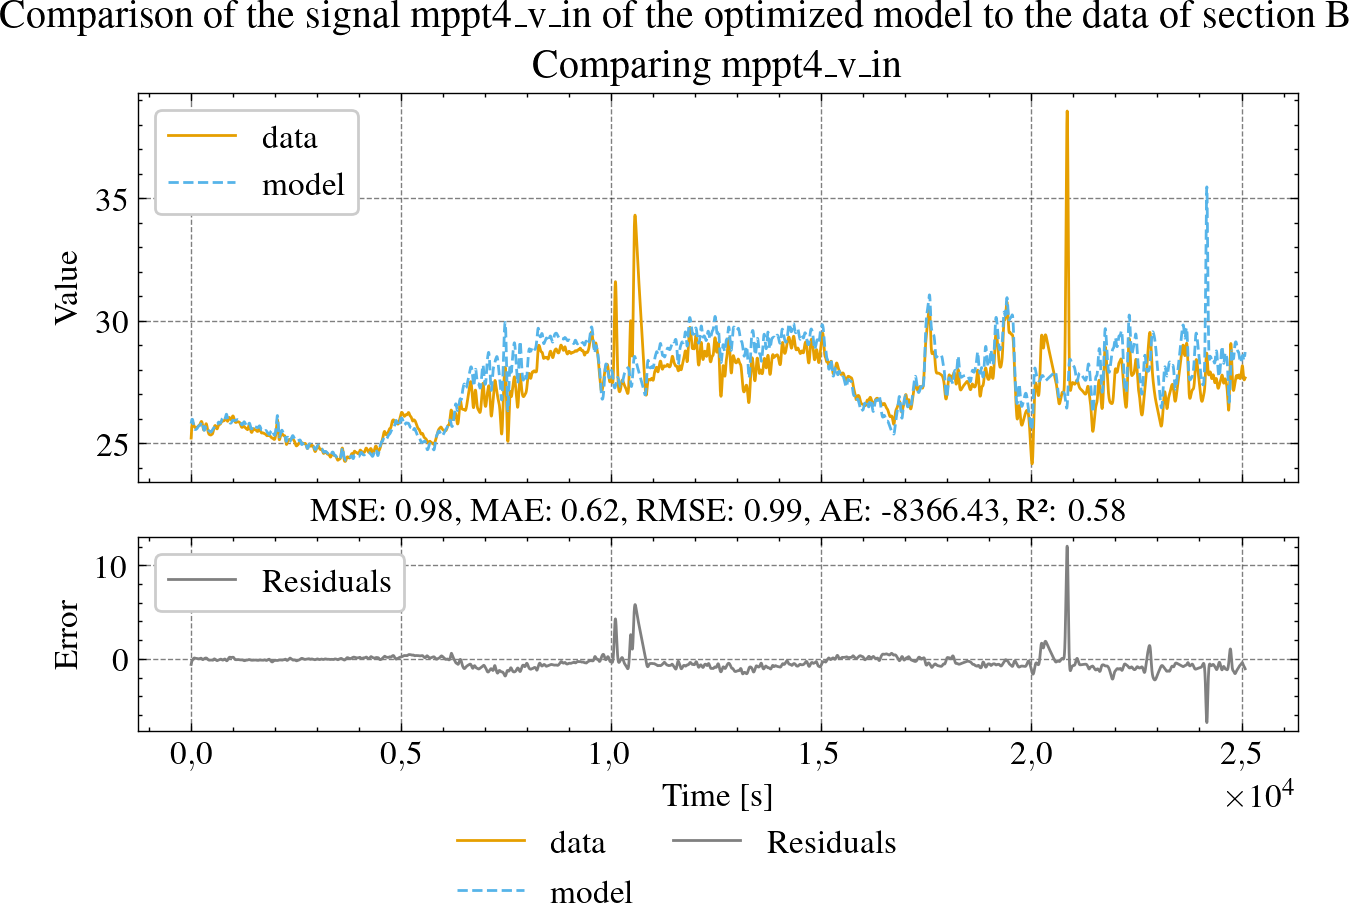

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_out_test_c.pdf


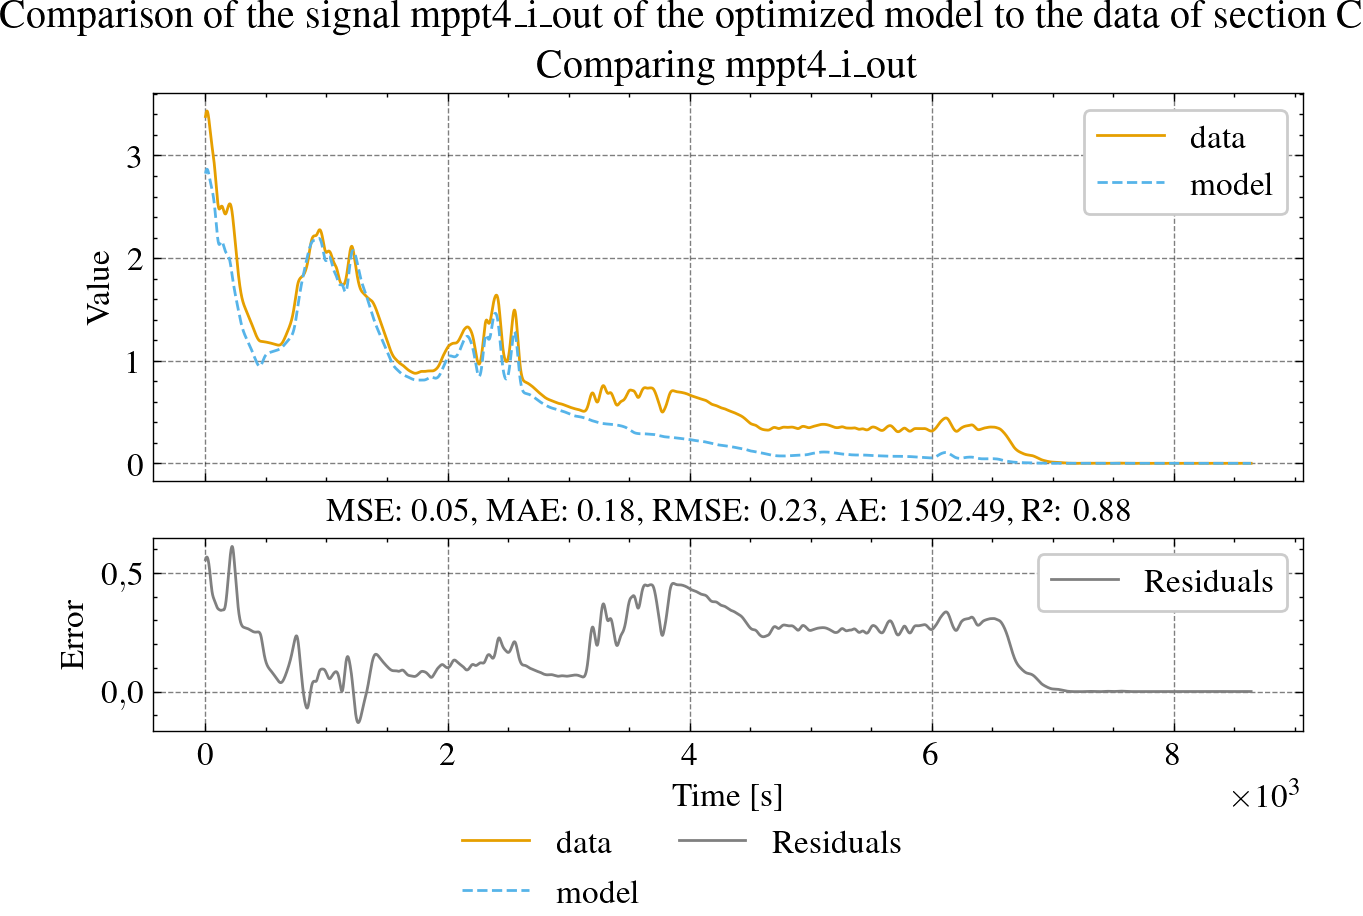

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_in_test_c.pdf


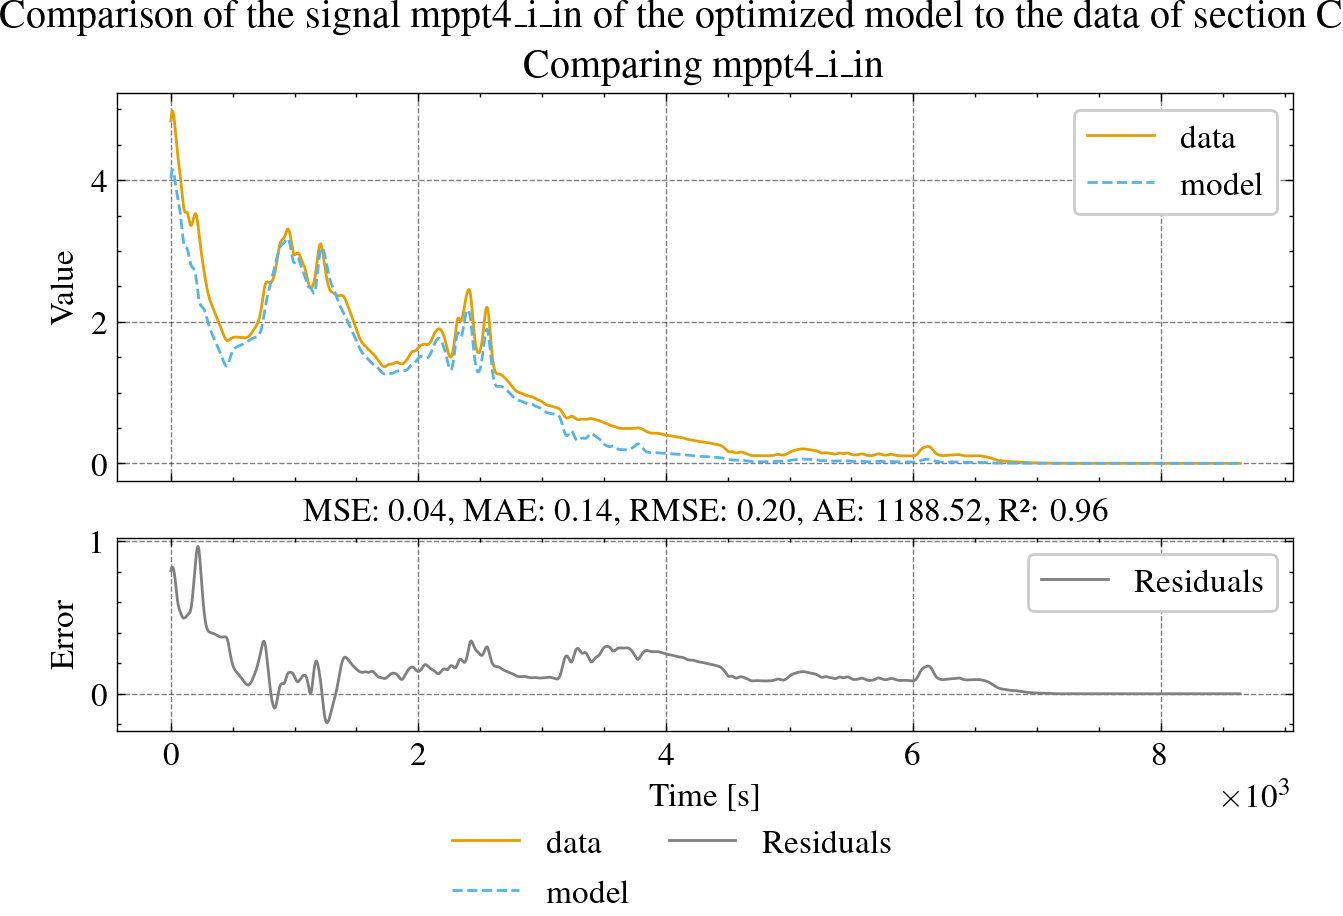

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_v_in_test_c.pdf


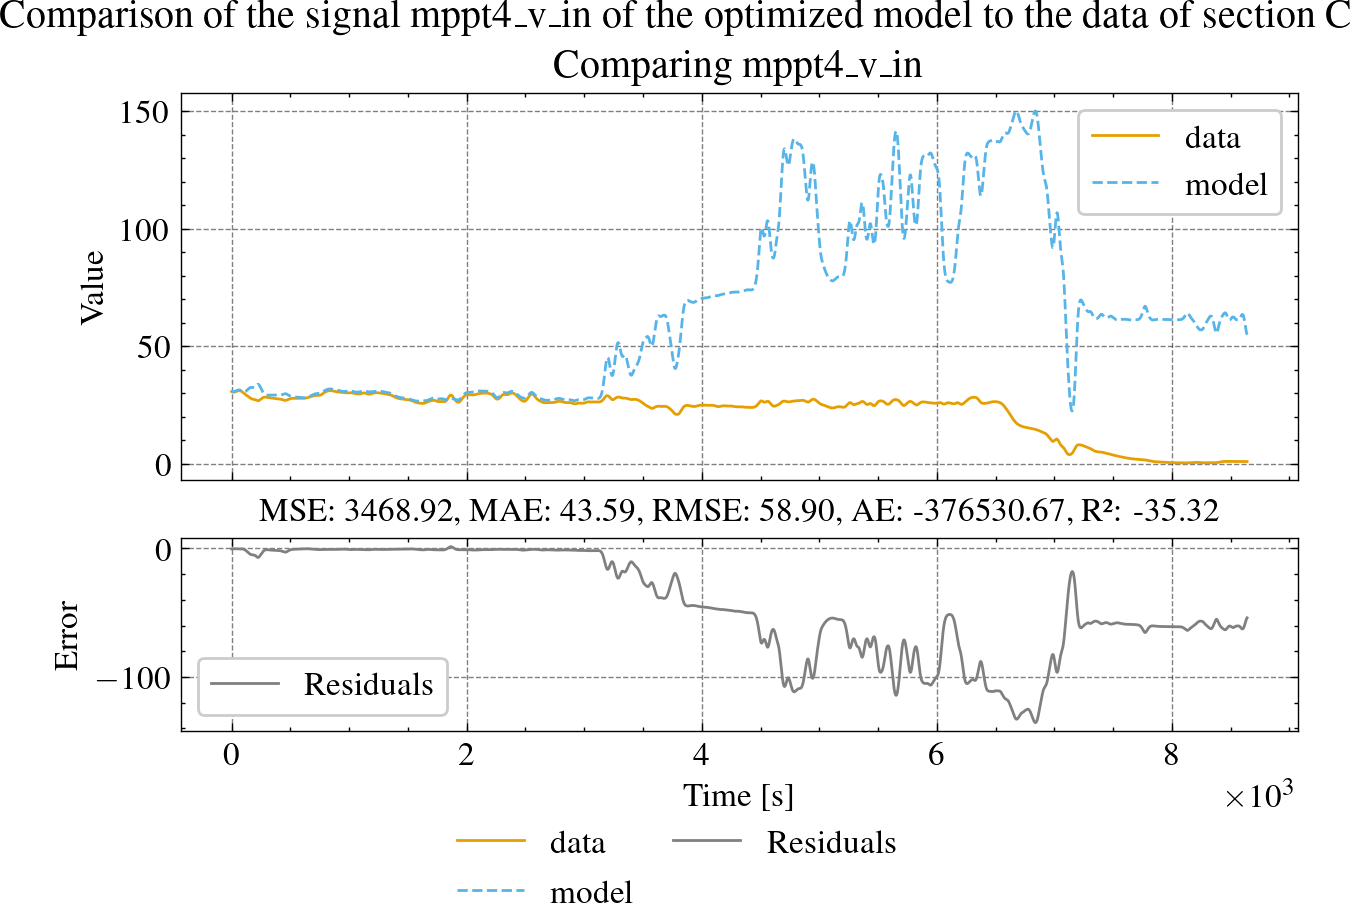

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_out_test_d.pdf


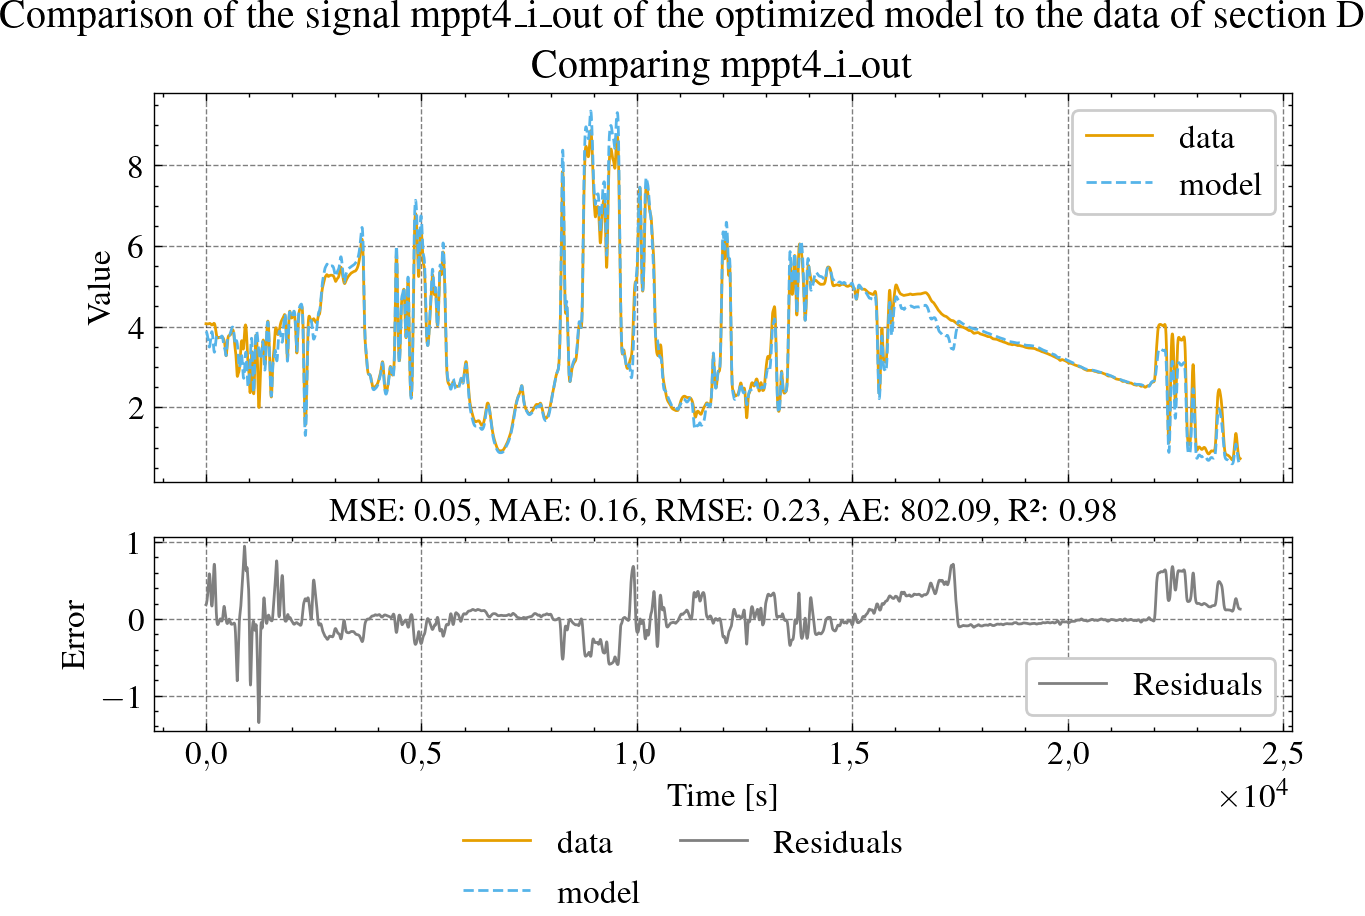

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_in_test_d.pdf


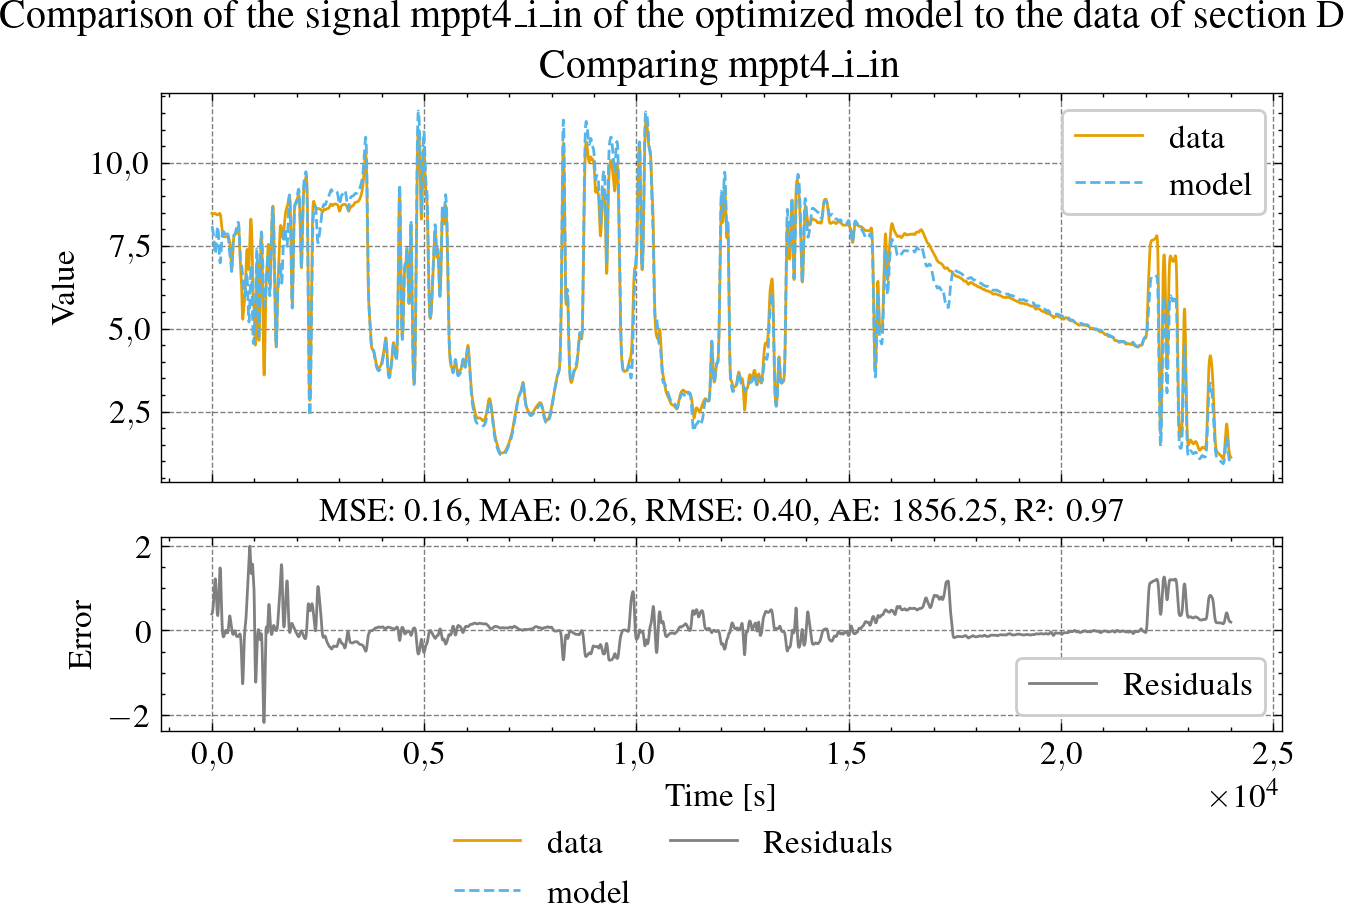

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_v_in_test_d.pdf


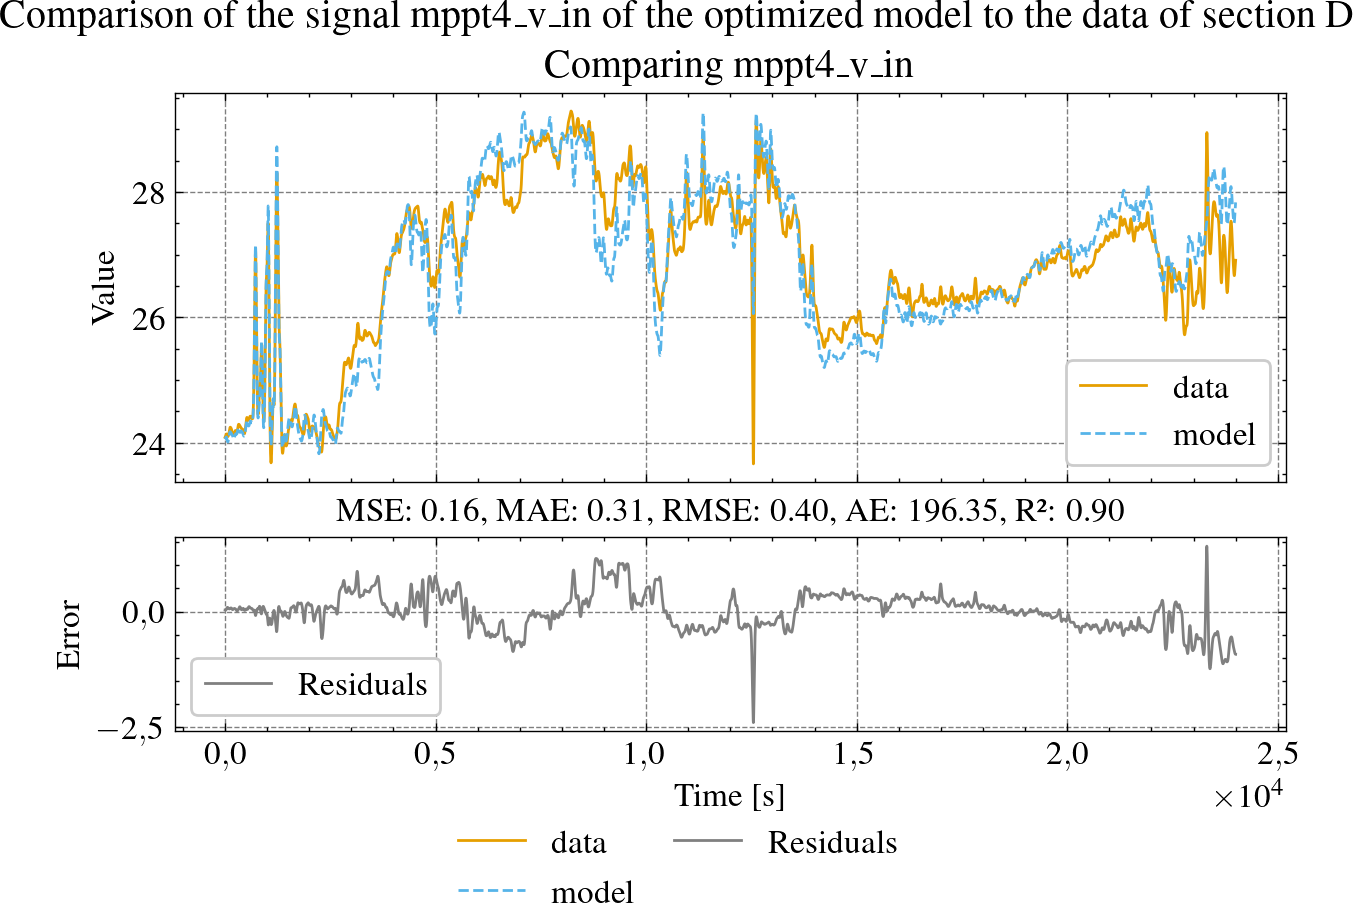

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_out_test_e.pdf


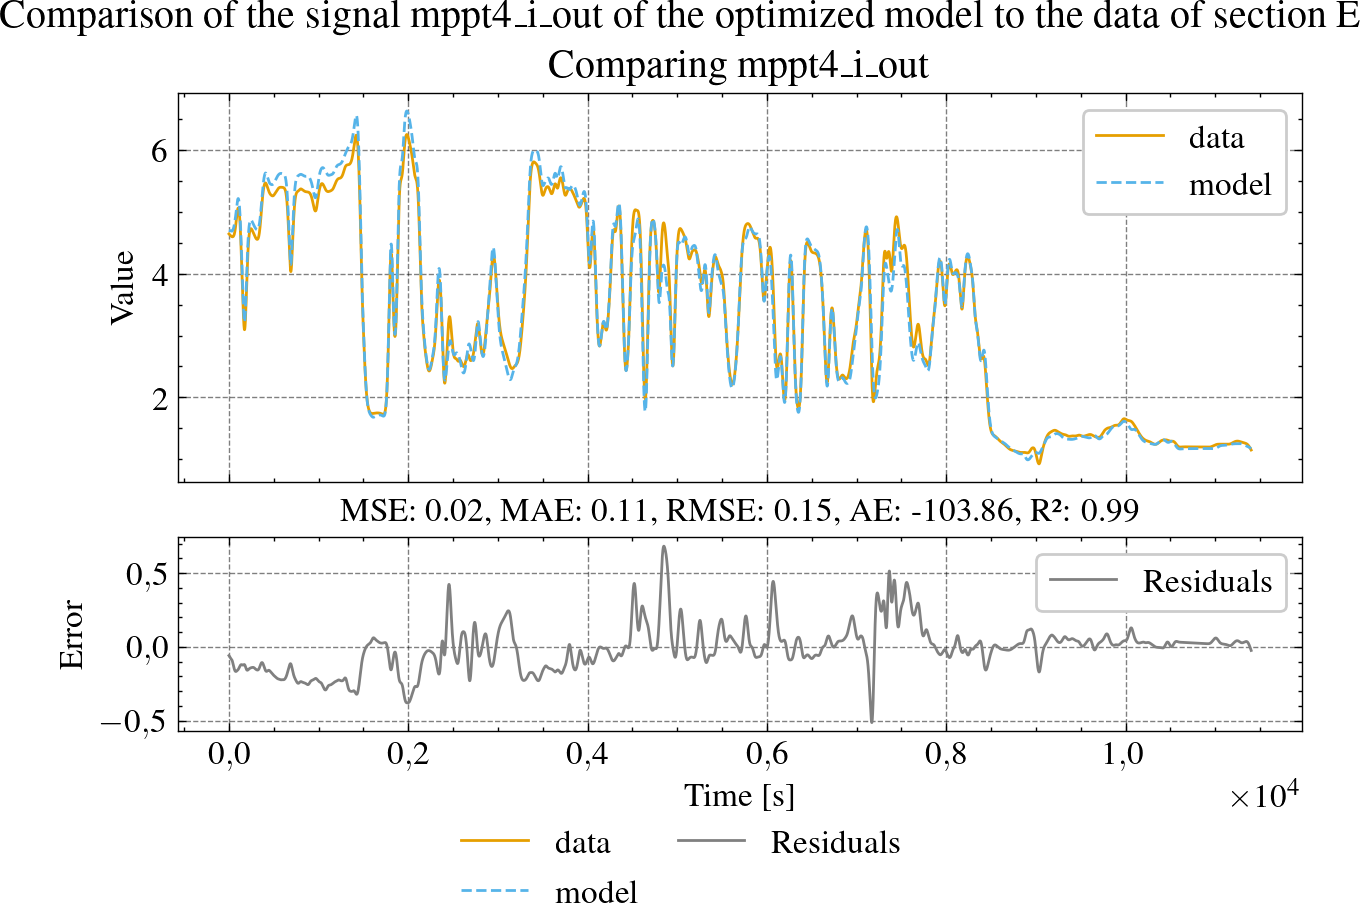

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_in_test_e.pdf


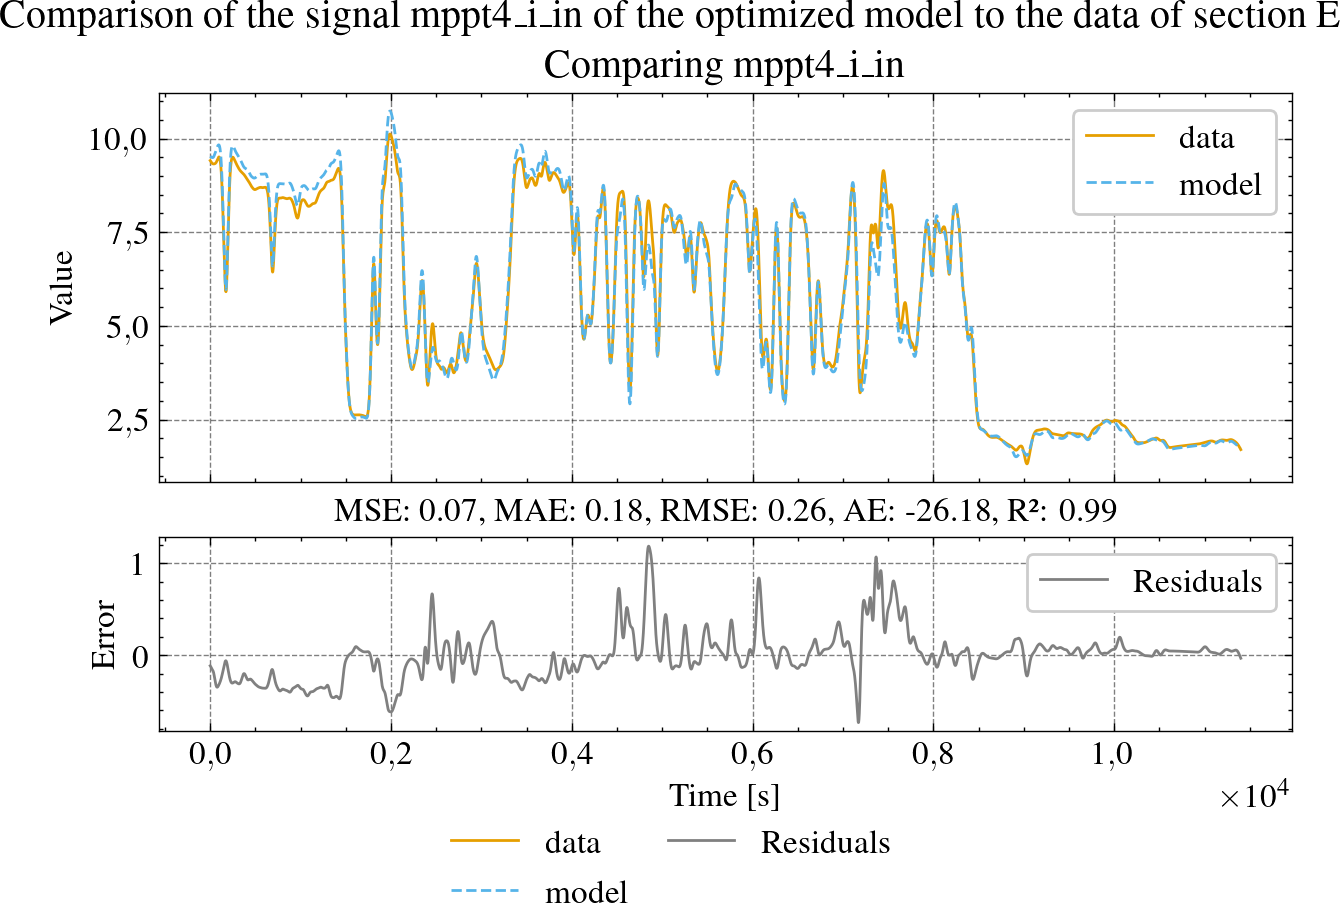

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_v_in_test_e.pdf


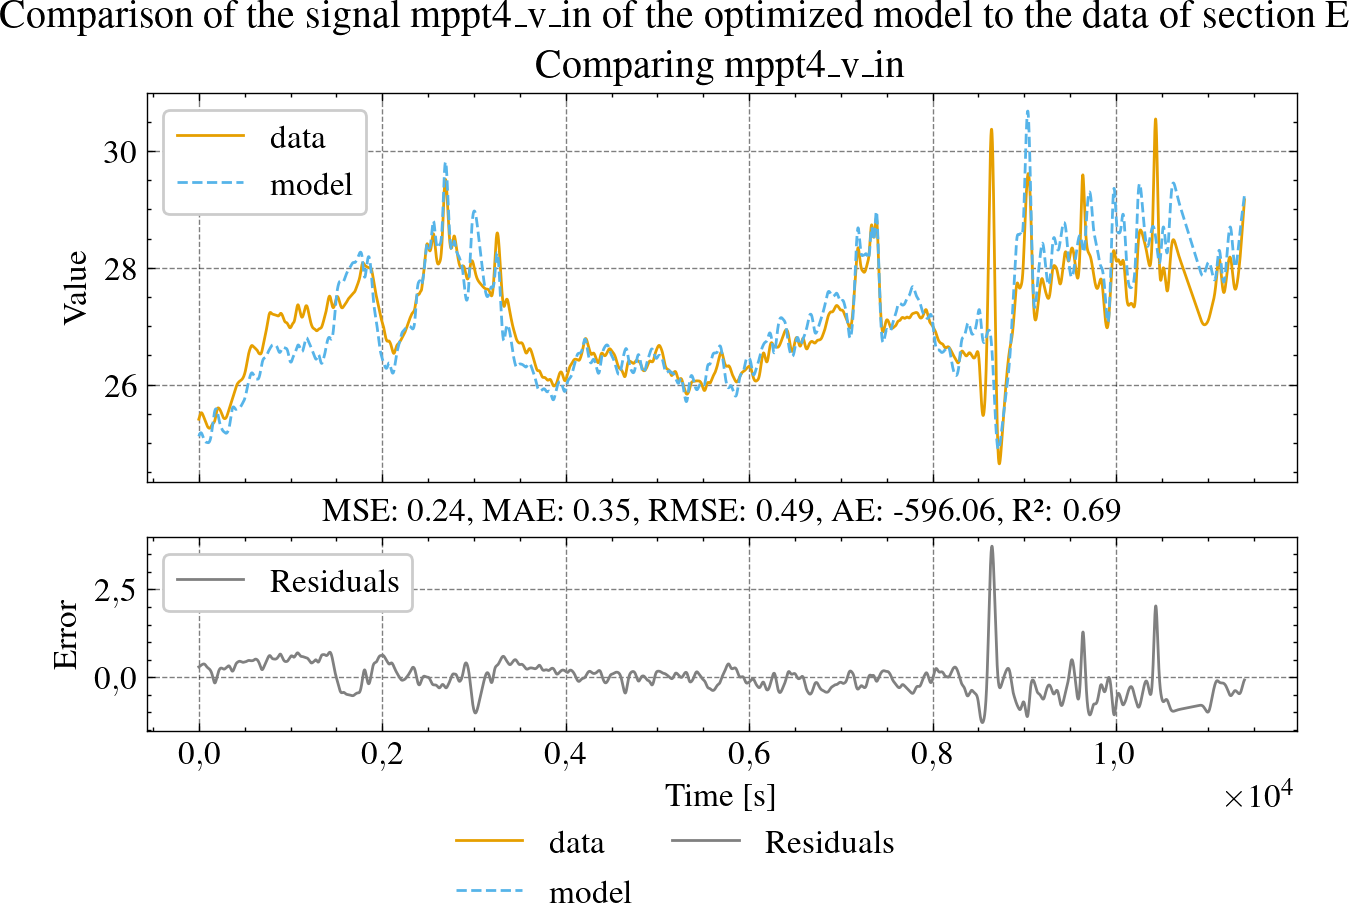

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_out_test_f.pdf


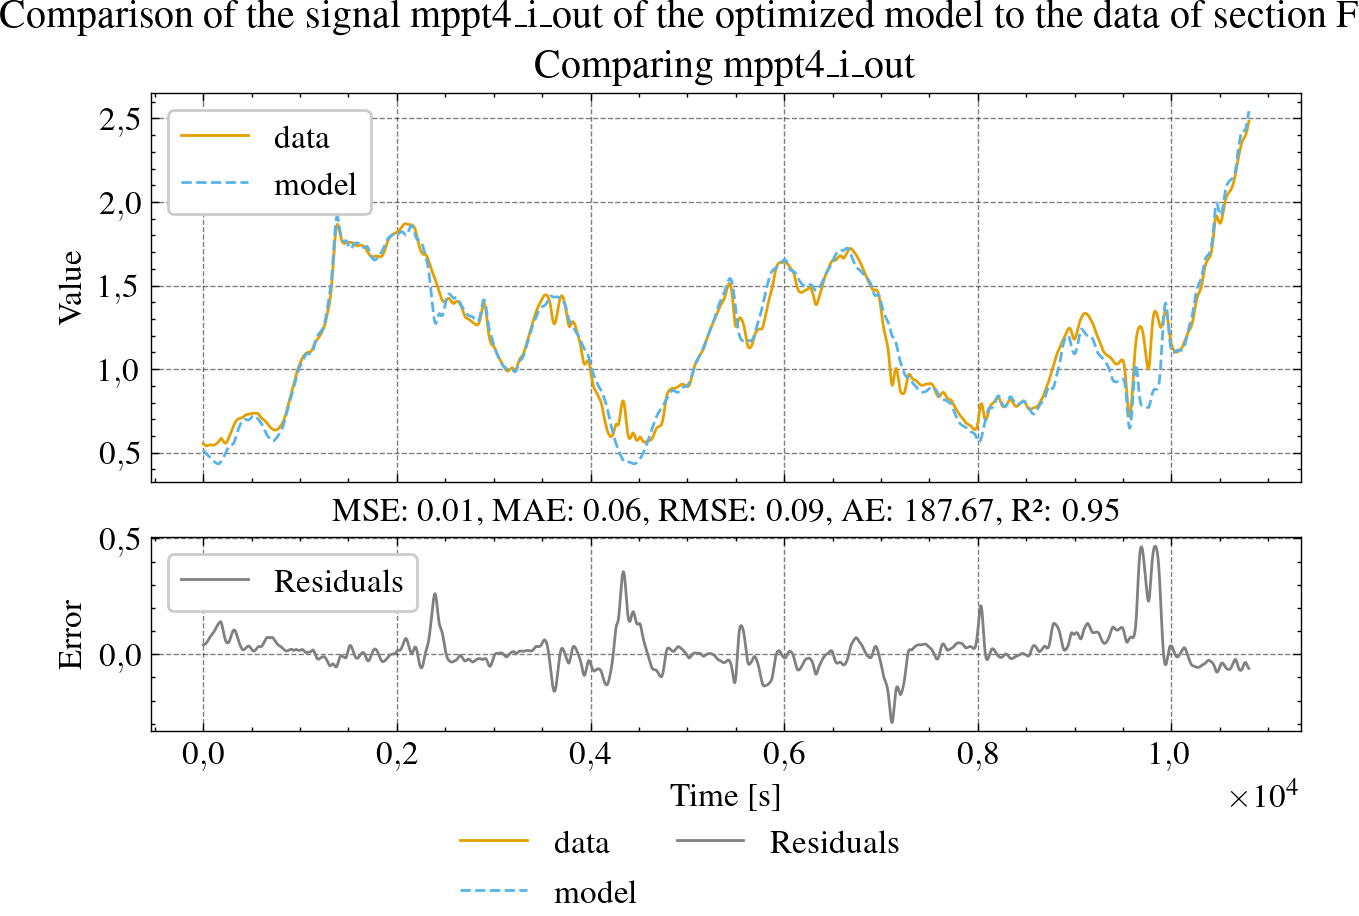

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_i_in_test_f.pdf


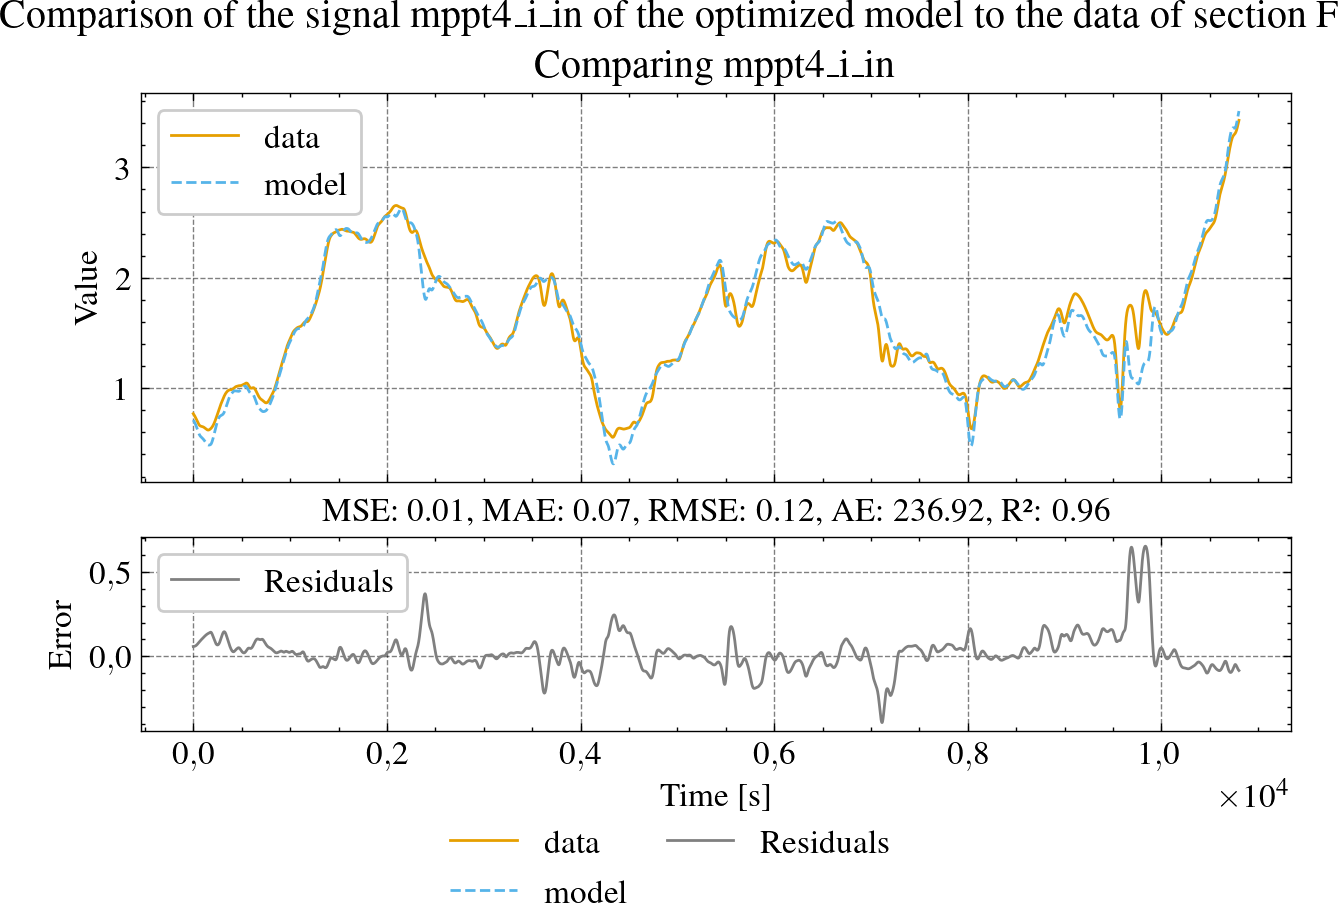

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_v_in_test_f.pdf


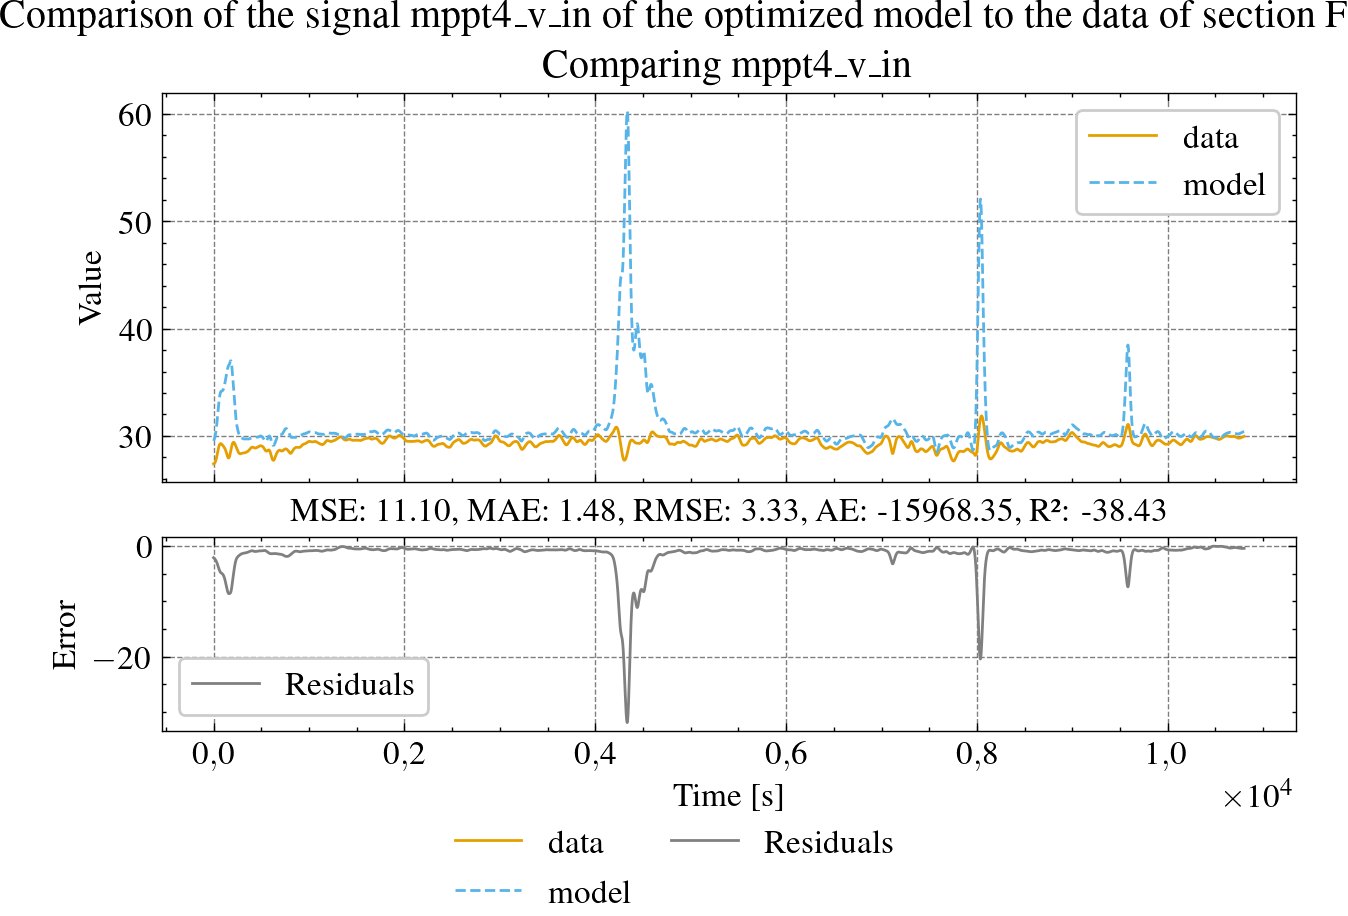

In [10]:
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/generation_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [11]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:generation_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/generation_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

Ignoring section A  because of insufficient size


MSE        MAE       RMSE             AE  \
section data                                                            
B       mppt4_i_out     0.009733   0.074290   0.098655    1265.975902   
        mppt4_i_in      0.028488   0.119942   0.168783    2082.175933   
        mppt4_v_in      0.982852   0.617698   0.991389   -8366.425971   
C       mppt4_i_out     0.051047   0.176527   0.225936    1502.485491   
        mppt4_i_in      0.039108   0.141294   0.197757    1188.518873   
        mppt4_v_in   3468.917832  43.586677  58.897520 -376530.668098   
D       mppt4_i_out     0.054779   0.157968   0.234049     802.090851   
        mppt4_i_in      0.156265   0.255523   0.395303    1856.246780   
        mppt4_v_in      0.161178   0.310198   0.401470     196.350031   
E       mppt4_i_out     0.023756   0.109166   0.154130    -103.855318   
        mppt4_i_in      0.067847   0.179710   0.260474     -26.182069   
        mppt4_v_in      0.240649   0.349340   0.490560    -596.059298   
F       mppt4_i_out     0.008043   0.056014   0.089684     187.668634   
        mppt4_i_in      0.013879   0.074119   0.117807     236.924071   
        mppt4_v_in     11.101431   1.478414   3.331881  -15968.349582   

                            R2  
section data                    
B       mppt4_i_out   0.995195  
        mppt4_i_in    0.996107  
        mppt4_v_in    0.584344  
C       mppt4_i_out   0.883011  
        mppt4_i_in    0.963372  
        mppt4_v_in  -35.315711  
D       mppt4_i_out   0.976217  
        mppt4_i_in    0.972409  
        mppt4_v_in    0.895340  
E       mppt4_i_out   0.989645  
        mppt4_i_in    0.990440  
        mppt4_v_in    0.690918  
F       mppt4_i_out   0.949227  
        mppt4_i_in    0.958517  
        mppt4_v_in  -38.428457